In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout,Input,concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler,ModelCheckpoint

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
train_features.shape
img_cols
num_classes

10

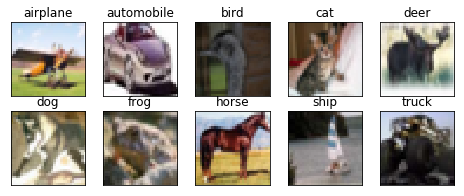

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Defining Functional Model

In [0]:
Input_img = Input(shape =(32,32,3))
x = Convolution2D(32,3,3,activation= 'relu')(Input_img) #Normal Convolution - 30x30
x = Convolution2D(32,3,1,activation = 'relu')(x) #spatially seperable Covolution 
x = Convolution2D(64,1,3,activation = 'relu')(x) #Spatially seperable Convolution - 28x28
x = SeparableConv2D(128,3,3,activation = 'relu')(x) # depthwise seperable Convolution - 26x26
x = MaxPooling2D((2,2))(x) # - 13x13
x = Dropout((0.20))(x)
#grouped Convoltion 1
g1 = Convolution2D(64,1,1,border_mode = 'same',activation = 'relu')(x) # - 13x13
g1 = Convolution2D(128,3,3,border_mode = 'same',activation = 'relu')(g1)# - 13x13
g2 = Convolution2D(64,1,1,border_mode = 'same',activation = 'relu')(x)# - 13x13
g2 = Convolution2D(128,5,5,border_mode = 'same',activation = 'relu')(g2)# - 13x13
g = concatenate([g1,g2],axis = 1)# - 13x13
g = MaxPooling2D((2,2))(g) # - 6x6
g = Dropout((0.20))(g)
#grouped Convoltion 2
g1d = Convolution2D(64,1,1,border_mode = 'same',activation = 'relu')(g)
g1d = Convolution2D(128,3,3,border_mode = 'same',activation = 'relu')(g)
g2d = Convolution2D(64,1,1,border_mode = 'same',activation = 'relu')(g)
g2d = Convolution2D(128,3,3,border_mode = 'same',activation = 'relu',dilation_rate=2)(g)
gd = concatenate([g1d,g2d],axis = 1)
gd = MaxPooling2D((2,2))(gd) # - 3x3

gd = Convolution2D(10,1,1,activation = 'relu')(gd) #- 3x3
gd = Convolution2D(10,3,3)(gd) # - 1x1 
gd = Flatten()(gd)
output = Dense(10, activation='softmax')(gd)


model = Model(inputs = Input_img, outputs = output)
model.summary()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), activation="relu")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 3), activation="relu")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(128, (3, 3), activation="relu")`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (1, 1), activation="relu", padding="same")`
  if __name__ == '_

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_89 (Conv2D)              (None, 30, 30, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 28, 30, 32)   3104        conv2d_89[0][0]                  
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 28, 28, 64)   6208        conv2d_90[0][0]                  
__________________________________________________________________________________________________
separable_

In [0]:
def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)
callbacks = [LearningRateScheduler(scheduler, verbose=1)]
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 40s 102ms/step - loss: 1.8028 - acc: 0.3320 - val_loss: 1.4935 - val_acc: 0.4448
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
390/390 [==============================] - 38s 97ms/step - loss: 1.3552 - acc: 0.5088 - val_loss: 1.2188 - val_acc: 0.5639
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
390/390 [==============================] - 38s 99ms/step - loss: 1.1544 - acc: 0.5858 - val_loss: 1.0517 - val_acc: 0.6266
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
390/390 [==============================] - 38s 97ms/step - loss: 1.0103 - acc: 0.6423 - val_loss: 0.9614 - val_acc: 0.6563
Epoch 5/50

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
390/390 [==============================] - 38s 98ms/step - loss: 0.9166 - acc: 0.676

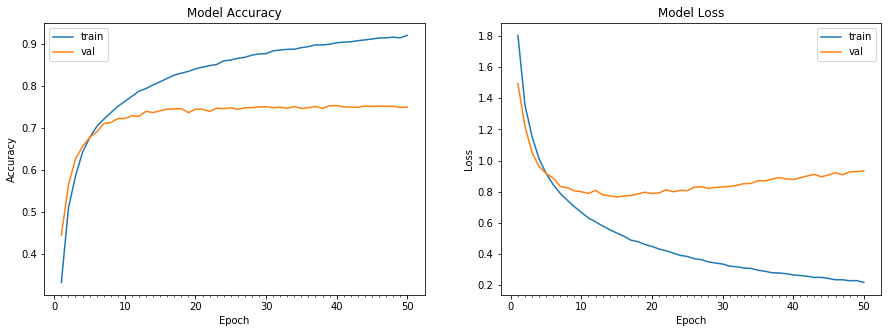

Accuracy on test data is: 75.02


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels),  callbacks=callbacks,verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))